In [2]:
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

2021-10-26 19:39:24.348713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-26 19:39:24.349925: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df_23043 = pd.read_csv("../data/datasets_by_whale/1999CA-Bmu-23043.csv")[["location-long", "location-lat"]] 
#whale with largest route

### Split data for train and test 

In [4]:
def split_data(df):

    n = len(df)
    train_df = df[0:int(n*0.7)]
    test_df = df[int(n*0.7):]

    num_features = df.shape[1]
    
    return train_df,test_df

In [5]:
train_df,test_df = split_data(df_23043)

### Create data windows 

In [6]:
def data_windowing(train_df,test_df):
    n_points = 20
    window_length = n_points+ 1 
    
    window_train = tf.keras.utils.timeseries_dataset_from_array(
    train_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)

    window_test = tf.keras.utils.timeseries_dataset_from_array(
    test_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)

    return window_train, window_test

In [7]:
window_train,window_test = data_windowing(train_df,test_df)

2021-10-26 19:39:29.657619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-26 19:39:29.657689: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-26 19:39:29.658160: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R3AGIN3): /proc/driver/nvidia/version does not exist
2021-10-26 19:39:29.661345: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Splits windows in X,y

In [8]:
def data_map(elem):
    n_points = 20
    window_length = n_points+ 1 
    X,y = elem[:,:-1,:],elem[:,-1:,0:2] # X= features; y = labels(the next coordenate point)
    X.set_shape([None, n_points, None])
    y.set_shape([None, window_length - n_points, None])
    
    return (X,y)


In [9]:
train = window_train.map(data_map)
test = window_test.map(data_map)

### Trainning a neural network model

In [10]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=2)
])

In [11]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=0.0005),metrics=[tf.metrics.MeanAbsoluteError()])

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=5,
                                                mode='min')

tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=2)

history = lstm_model.fit(train, epochs=100,
                         validation_data=test,
                         callbacks=[early_stopping, tensorboard_callback])


2021-10-26 19:39:31.644651: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-26 19:39:31.644693: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-26 19:39:31.647852: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-26 19:39:31.709897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
6/9 [===================>..........] - ETA: 0s - loss: 7769.2056 - mean_absolute_error: 77.4447

2021-10-26 19:39:33.353145: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-26 19:39:33.353193: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-26 19:39:33.371320: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-26 19:39:33.380114: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-26 19:39:33.421588: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_26_19_39_33

2021-10-26 19:39:33.436709: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_26_19_39_33/DESKTOP-R3AGIN3.trace.json.gz
2021-10-26 19:39:33.457922: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_26_19_39_33

2021-10-26 19:39:33.

9/9 [==============================] - 2s 79ms/step - loss: 7854.1509 - mean_absolute_error: 77.9715 - val_loss: 7266.6812 - val_mean_absolute_error: 73.2479
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 7787.9834 - mean_absolute_error: 77.8290 - val_loss: 7193.4189 - val_mean_absolute_error: 73.0820
Epoch 3/100
9/9 [==============================] - 0s 25ms/step - loss: 7706.1304 - mean_absolute_error: 77.6378 - val_loss: 7097.4028 - val_mean_absolute_error: 72.8514
Epoch 4/100
9/9 [==============================] - 0s 22ms/step - loss: 7597.9082 - mean_absolute_error: 77.3701 - val_loss: 6970.7021 - val_mean_absolute_error: 72.5266
Epoch 5/100
9/9 [==============================] - 0s 18ms/step - loss: 7463.0186 - mean_absolute_error: 77.0108 - val_loss: 6807.6001 - val_mean_absolute_error: 72.0782
Epoch 6/100
9/9 [==============================] - 0s 18ms/step - loss: 7280.8154 - mean_absolute_error: 76.4969 - val_loss: 6607.3359 - val_mean_absolute_error: 

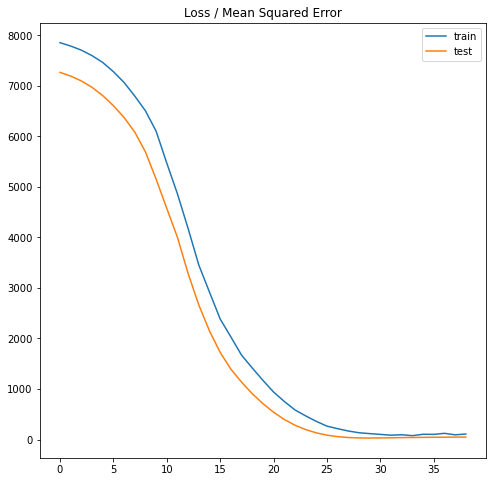

In [13]:
pyplot.figure(figsize=(8,8))
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [14]:
test_df[:21]

,location-long,location-lat
290,-123.140,37.667
291,-122.513,37.741
292,-123.055,37.716
293,-123.105,37.725
294,-123.265,37.712
295,-123.220,37.522
296,-123.032,37.607
297,-123.182,37.659
298,-122.890,37.546
299,-122.928,37.625


In [15]:
np.array([list(test.take(1).as_numpy_iterator())[0][0][0]]).shape

(1, 20, 2)

In [16]:
lstm_model.layers[0].input_shape

(None, 20, 2)

In [17]:
y_pred = lstm_model.predict(np.array([test_df[:20]]))[0]

In [18]:
y_pred

array([-120.875885,   35.12094 ], dtype=float32)

In [19]:
test_df.iloc[21]

location-long   -123.031
location-lat      37.511
Name: 311, dtype: float64

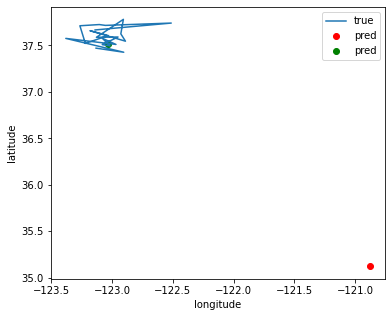

In [20]:
pyplot.figure(figsize=(6,5))
pyplot.plot(test_df[:20]["location-long"], test_df[:20]["location-lat"], label='true')
pyplot.scatter(y_pred[0], y_pred[1],  c="red", label='pred')
pyplot.scatter(test_df.iloc[21][0], test_df.iloc[21][1],  c="green", label='pred')
pyplot.xlabel("longitude")
pyplot.ylabel("latitude")
pyplot.legend()
pyplot.show()

### Predicting a new route

In [21]:
route_predict = test_df[:20]
new_points = 10
for n in range(new_points):
    n = n+1
    points = np.array([route_predict[n:20+n]])
    r_predict=lstm_model.predict(points)
    route_predict = route_predict.append(pd.DataFrame(r_predict, columns=["location-long", "location-lat"]), ignore_index=True)
    
print(route_predict) #Predicción de 10 puntos nuevos 


    location-long  location-lat
0     -123.140000     37.667000
1     -122.513000     37.741000
2     -123.055000     37.716000
3     -123.105000     37.725000
4     -123.265000     37.712000
5     -123.220000     37.522000
6     -123.032000     37.607000
7     -123.182000     37.659000
8     -122.890000     37.546000
9     -122.928000     37.625000
10    -122.907000     37.781000
11    -123.129000     37.588000
12    -122.951000     37.591000
13    -123.081000     37.509000
14    -123.017000     37.495000
15    -123.080000     37.577000
16    -122.968000     37.511000
17    -123.381000     37.576000
18    -122.904000     37.427000
19    -123.132000     37.471000
20    -120.875870     35.120926
21    -120.844711     35.111256
22    -120.844574     35.111225
23    -120.844574     35.111229
24    -120.844566     35.111221
25    -120.844559     35.111221
26    -120.844559     35.111217
27    -120.844566     35.111217
28    -120.844551     35.111214
29    -120.844528     35.111214


In [22]:
route_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location-long  30 non-null     float64
 1   location-lat   30 non-null     float64
dtypes: float64(2)
memory usage: 608.0 bytes


In [23]:
route_predict.to_csv("../data/predict.csv", index=False)

In [24]:
from folium import Map, Marker, PolyLine

In [25]:
route = route_predict.to_numpy()

In [26]:
 m = Map([28.773552, -115.176131])

for point in route:
    Marker(location=[point[1], point[0]]).add_to(m)

In [27]:
m